In [134]:
#Authors: Eli Gumble, Peter Brommer, Harry Brown
#Initialisation
import matplotlib.pyplot as plt
import numpy as np
#from scipy.integrate import simps
from scipy import signal as sg
from scipy.interpolate import RectBivariateSpline as ReBiSpline 
from numpy import ma
#from matplotlib import colors, ticker, cm
#from random import choice
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology
import timeit
import math
#from PIL import Image

import matplotlib.image as image2
import itertools
from scipy import ndimage
import multiprocessing
from multiprocessing import Pool
import multiprocessedfunctions as mpf
import multiprocessedfunctions2 as mpf2
from globalparameters import * # parameters below have been relocated into globalparameters.py
#from scipy import stats
#import statistics
from datetime import datetime
import time


%matplotlib inline

In [135]:
# Read grids from image
#im = Image.open("belgiumtest.bmp")
#Base = np.array(im)

#im = image2.imread("belgiumtestorig2x.bmp")
im = image2.imread("empty800x800grass.bmp")
Base = np.array(im)


In [136]:

#print(Base[0,0,1])
#Base = np.where(Base[:,:,0]==43, 0, Base)
#Base

#                        [[r, g, r2, g2]...]     description
landcoverlist = np.array([[22, 95, 0, 0],           # water
                          [209, 209, 150, 150],       # bare floor
                          [139, 139, 175, 175],     # artificial surface
                          [221, 5, 0, 0],           # building
                          #[0, 0, 0, 0],            # herbaceous cover in rotation throughout year
                          [234, 255, 60, 175],       # herbaceous cover (grass)
                          [40, 202, 60, 80],        # tall hardwood > 3m
                          [185, 233, 40, 80],       # short hardwood < 3m
                          [1, 47, 65, 80],          # tall softwood > 3m
                          #[0, 0, 0, 0],            # short softwood < 3m
                          [43, 80, 0, 0]])          # boundary
                                        
#len(landcoverlist)

for k in range (len(landcoverlist)):
    for i in range(len(Base)):             #vertical pixels
        for j in range(len(Base[0])):      #horizontal pixels
            if Base[i][j][0] == landcoverlist[k,0] and Base[i][j][1] == landcoverlist[k,1]:
                Base[i][j] = [landcoverlist[k,2],landcoverlist[k,3],0,255]


In [137]:
Base[:,:,2] = 0 #set all pixel B values to 0

Base[:,:,3] = 255 #set all of the 4th rgb element to 255 because things might break otherwise

In [138]:
# Define internal quantities and variables
scale = 1./2. #m per pixel
Nx = Base[:,0,0].size #N appears to be resolution
Ny = Base[0,:,0].size
xmin=-scale*0.5*(Nx-1)
xmax=scale*0.5*(Nx-1)
ymin=-scale*0.5*(Ny-1)
ymax=scale*0.5*(Ny-1)
x = np.linspace(xmin, xmax, Nx) # This is defining the axes and full space
y = np.linspace(ymin, ymax, Ny)
Y, X= np.meshgrid(y, x)
TrailPotential = np.zeros((Nx,Ny))
DestinationPotential=np.zeros((Nx,Ny))
Weight=np.zeros((Nx,Ny))  # Create gradient to sit on Nx, Ny
intens=np.zeros((Nx,Ny))
q_alpha=np.zeros((Nx,Ny))
expdist=np.zeros((2*Nx-1,2*Ny-1))
dest=np.zeros((2))
start=np.zeros((2))
grad=np.zeros((2,Nx,Ny))
vel=np.asarray([0.,0.])
pos=np.asarray([0.,0.])
stalledpos = [] # empty container for stalled positions of walkers
stalledposrounded = []

intens[:]=0.

#print(route)
'''
#parameters
t_track=50. # Track decay time - after 50 walkers ignore a trail, it decays by 1/e
wlkr_range = 10000
dt=0.1  # dt per time step, continuous markings every dt metres
dvel=1. # desired walker velocity in m/s
tau=5.
isigma=0.5 # trail potential
trailpotweight = 0.004 # weighting of trail potential over destination potential, started as 0.003, increasing this increases number of stalls
storedtrailpotweight = trailpotweight
conv_thresh=10.e-4
precision=1.**2 #distance to target.
eps=0.025 #random motion contribution, same for all
'''

'\n#parameters\nt_track=50. # Track decay time - after 50 walkers ignore a trail, it decays by 1/e\nwlkr_range = 10000\ndt=0.1  # dt per time step, continuous markings every dt metres\ndvel=1. # desired walker velocity in m/s\ntau=5.\nisigma=0.5 # trail potential\ntrailpotweight = 0.004 # weighting of trail potential over destination potential, started as 0.003, increasing this increases number of stalls\nstoredtrailpotweight = trailpotweight\nconv_thresh=10.e-4\nprecision=1.**2 #distance to target.\neps=0.025 #random motion contribution, same for all\n'

In [139]:
##Set up map
#Create blank arrays for map 
z = np.zeros((Nx,Ny))
g_max=np.zeros((Nx,Ny))
g_nat=np.zeros((Nx,Ny))

g_nat=np.maximum(np.ones_like(g_nat),np.float64(Base[:,:,0]))
g_max=np.maximum(np.ones_like(g_max),np.float64(Base[:,:,1]))
z=g_nat

track_labels=Base[:,:,2]

numpoints=np.max(track_labels)

point=np.zeros((numpoints,2))

for i in range(0,Nx):
    for j in range(0,Ny):
        if (track_labels[i,j]>0):
            point[track_labels[i,j]-1]=np.array([i,j])
print (point)

# Trails (start and end point) For current Map, coordinates in metres, centre of image = (0,0)

# single possible path
# route=np.array([[24.,-9.75],[-24.,9.75]]),


[]


In [140]:

# big field with tennis court parking lot and hospital, near rue cottrel
ptA = [-40.,-240.]      # tennis court near middle
ptB = [-250.,-200.]     # tennis court near skatepark
#ptC = [-350., 25.]     # parking lot entrance >>>>>>>>>>>>> removed because its very close to ptD, won't give interesting information, not worth computational work
ptD = [-350., 80.]      # parking lot bus stop
ptE = [-70., 230.]      # east road pedestrian entrance
ptF = [200., 200.]      # hospital bus stop
ptG = [250., 100.]      # hospital side path
ptH = [350., -100.]     # dirt car park
ptI = [210., -140.]     # west side entrance

#listofdestinations = [ptA,ptB,ptD,ptE,ptF,ptG,ptH,ptI,ptA,ptB,ptD,ptE,ptF,ptG,ptH,ptI] # list is repeated so that the combinations function below generates not only AB but BA
listofdestinations = [[0,50],[-10,-50],[10,-50],[0,50],[-10,-50],[10,-50]]
route = []

# should probably turn all of this into a function

# generate routes
for i in itertools.combinations(listofdestinations, 2):
    route.append(i)

# remove duplicate routes https://stackoverflow.com/questions/2213923/removing-duplicates-from-a-list-of-lists
routetemp = []
for i in route:
    if i not in routetemp:
        routetemp.append(i)
route = routetemp

# delete AA, BB, CC routes
zzzzz = -1
for row in route:
    zzzzz+=1
    if row[0] == row[1]:
        route.pop(zzzzz)

routearray = np.empty((len(route),2,2))

# convert list of lists to 3d array
for k in range(len(route)):
    for i in range(2):
        for j in range(2):
            routearray[k][i][j] = route[k][i][j]

route = routearray # convert routearray back to variable name understood by code
#route = [[[0,100],[-25,0]],[[0,100],[25,0]]]

In [141]:

#for i in listofdestinations
#    route[i,0:len(listofdestinations)] = listofdestinations[i]

# small field by apartment with 4 entrances 
#posA = [-5., -17.]
#posB = [-25., -17.]
#posC = [-25., 8.]
#posD = [40., 10.]

# acceptable routes = A/B to C, A/C to D and vice versa, 8 total routes
#route=np.array([[posA,posC],
#                 [posB,posC],
#                 [posC,posA],
#                 [posC,posD],
#                 [posA,posC],
#                 [posC,posD],
#                 [posD,posA],
#                 [posD,posC],
#                 ])


In [142]:
#Setup weight matrix, here trapezoid rule.
Weight[:,:]=1
Weight[1:-1,:]=2
Weight[:,1:-1]=2
Weight[1:-1,1:-1]=4
Weight*=0.25*((x[-1]-x[0])/(Nx-1))*((y[-1]-y[0])/(Ny-1))
#0.25*((x[-1]-x[0])/(N-1))*((y[-1]-y[0])/(N-1))
#np.exp(-np.sqrt((x[:,None]-x[N/2])**2+(y[None,:]-y[N/2])**2))*z[:,:]

In [143]:
# Setup distance matrix
for xi in range(1,Nx+1):
    for yi in range(1,Ny+1):
        
        expdist[xi-1,yi-1]=np.exp(-isigma*np.sqrt((x[Nx-xi]-xmin)**2+(y[Ny-yi]-ymin)**2))
        expdist[-xi,-yi]  = expdist[xi-1,yi-1]
        expdist[-xi,yi-1] = expdist[xi-1,yi-1]
        expdist[xi-1,-yi] = expdist[xi-1,yi-1]
        
# find index range > conv_thresh
subexpdist=expdist[(expdist>conv_thresh).any(1)]
subexpdist=subexpdist[:, np.any(subexpdist>conv_thresh, axis=0)]
#subexpdist=subexpdist[:,np.any(subexpdist>conv_thresh, axis=0)]
#expdist[subexpdist]=0.
subexpdist.shape
#expdist
#subexpdist


(55, 55)

In [144]:
def calc_tr_new():
    TrailPotential[:,:]=sg.convolve2d(z[:,:]*Weight[:,:],subexpdist[:,:],mode="same")  # 2D convolution

In [145]:
len(TrailPotential)

800

In [146]:
def calc_tr_gauss():
    TrailPotential[:,:]=ndimage.gaussian_filter(z[:,:], 1, 0) #,TrailPotential,mode='nearest')

In [147]:
#Integrate z, trapezoid rule eq 20
#def calc_tr():
#    global xi,yi,tr,expdist,z,wght,Nx,Ny
#    for xi in range(0,Nx): 
#        for yi in range(0,Ny):
#            tr[xi,yi]=np.sum(expdist[Nx-1-xi:2*Nx-1-xi,Ny-1-yi:2*Ny-1-yi]*z[:,:]*wght[:,:])

In [148]:
timeit.timeit(calc_tr_new,number=1)

11.876699599999483

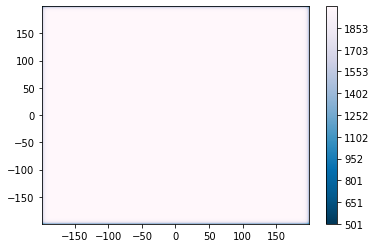

In [149]:
# Defines a Plot to show the smoothing of the supplied map to represent the respective potentials of the ground, the larger
# the potentials, the more attractive the ground is to the walker

cs = plt.contourf(X, Y, TrailPotential, levels=np.linspace(TrailPotential.min(),TrailPotential.max(),1000),cmap='PuBu_r')
cbar = plt.colorbar()

plt.show()
#plt.scatter(track[0:wlkr_range-1,0],track[0:wlkr_range-1,1])

In [150]:
#set up walker
def set_up_walker(route_id):
    global vel, pos, track, dest, start, route
    #start
    dispersion = 5 # length away from start point walkers are allowed to spawn, measured in m

    start = np.array(route[route_id, 0, :]) # commented for simplicity
    start[0] += np.random.randint(-dispersion, dispersion+1) # adds dispersion to x
    start[1] += np.random.randint(-dispersion, dispersion+1) # adds dispersion to y
    # start = np.array([24.,-9.75])  # temporary one route
    # dest = np.array([-24.,9.75])  # temporary one route
    # dest=(random.choice(ends))
    dest = np.array(route[route_id, 1, :]) # commented for simplicity
    dest[0] += np.random.randint(-dispersion, dispersion+1)
    dest[1] += np.random.randint(-dispersion, dispersion+1)
    vel = np.array([0., 0.])
    pos = np.array(start)
    #print (pos)
    track = np.zeros((wlkr_range, 2))
    #track[0,:]=pos[:]

In [151]:
#Calculate gradients eq 19
#Trail gradient
def setup_potentials():
    global grad,desdirx,desdiry,dest,trailpotweight
    grad=np.zeros((2,Nx,Ny))
    grad=trailpotweight*np.array(np.gradient(TrailPotential))
    #grad=0.002*np.array(np.gradient(TrailPotential)) ORIGINAL
    
    #print (dest)
    #Destination potential
    DestinationPotential=-np.sqrt((dest[0]-x[:,None])**2+(dest[1]-y[None,:])**2)
    #Combine gradients
    grad+=np.array(np.gradient(DestinationPotential)[:])
    #Normalise
    #grad[:,:,:]/=(np.sqrt(grad[0,:,:]**2+grad[1,:,:]**2))
    desdirx=ReBiSpline(x,y,grad[0,:,:],s=2) # gradeint plus magnitude, Spline approximation over a rectangular mesh
    desdiry=ReBiSpline(x,y,grad[1,:,:],s=2) 
    #plot()
    #print(grad)

In [152]:
# #Plot the direction
# scgrad=np.arctan2(grad[1],grad[0])
# levels = np.linspace(-np.pi, np.pi, 360)
# cs = plt.contourf(X, Y,scgrad, levels=levels,cmap='hsv')

# cbar = plt.colorbar()
# # ERROR # plt.scatter(track[0:wlkr_range-1,0],track[0:wlkr_range-1,1])
# #plt.scatter(start, dest)
# print(start)
# print(dest)
# plt.show()

In [153]:
# This function rounds a point, and checks if it is already in the list of rounded points
# If its already in the list it, it increases the count value for that point by 1
# If its not in the list, it adds it to the list with a count of 1

def stalledposregioncounter(newpos,stalledposrounded2):
    nearest = 5
    newposxrounded = round(newpos[0]/nearest)*nearest # round x
    newposyrounded = round(newpos[1]/nearest)*nearest # round y

    newposrounded = {"x":newposxrounded,"y":newposyrounded,"count":1}
    
    for i in stalledposrounded2:
        if i["x"] == newposrounded["x"] and i["y"] == newposrounded["y"]:
            i["count"]+=1
            return stalledposrounded2
    stalledposrounded2.append(newposrounded)
    return stalledposrounded2

In [154]:
def calc_path():
    global pos,vel,intens,track,dest,dvel,tau,stalledpos,stalledposrounded,trailpotweight,storedtrailpotweight
    
    i=0
    hist=10
    samp=10
    avpos=np.zeros((2,hist))
    internalclock = 0 # not measured in seconds, probably measured in 'dt's
    stallcounter = 0
    trailpotweight = 0.004 # weighting of trail potential over destination potential, started as 0.003, increasing this increases number of stalls
    storedtrailpotweight = trailpotweight

    # https://www.programiz.com/python-programming/datetime/current-time
    #now = datetime.now()
    #current_time = now.strftime("%H:%M:%S")
    #print("Calc path entered, time =", current_time)

    #Setup While loop to run until either the walker reaches the destination or the walker has passed 'wlkr_range' number of movement cycles to 
    #attempt to get there
    while (np.dot(pos-dest,pos-dest)>precision and i<wlkr_range):
    #set the postiion of the walker on its first then subsequent cycles
        
        #conditional logic saying to update the average position of the walker every 10 iterations
        #if (i%samp==0): avpos[:,(i%hist)//samp]=pos[:] #ORIGINAL
        if (i%samp==0): avpos[:,(i%(hist*samp))//samp]=pos[:]
            
        #print((i%hist)//samp)
        #print(avpos)
        
        gradmagnitude=max(0.0001,np.sqrt(desdirx(pos[0],pos[1])**2+desdiry(pos[0],pos[1])**2))
        xi=np.array(np.random.normal(0,1,2))
        # Equation 6 in Helbing, differential in position, eliminised velocity decay components
        # gradmagnitude makes sure it is normalised, desdir not normalised
        pos[0]+= dt *(dvel * desdirx(pos[0],pos[1])/gradmagnitude +np.sqrt(2.*eps/tau)*xi[0])  # x-position vector component 
        pos[1]+= dt *(dvel * desdiry(pos[0],pos[1])/gradmagnitude +np.sqrt(2.*eps/tau)*xi[1])  # y-position vector component
        
        internalclock+=1
        if internalclock == 250 and trailpotweight != storedtrailpotweight:
                trailpotweight = storedtrailpotweight
                #print(trailpotweight)
                setup_potentials() # recalculate potentials
        
#        posGrad = math.degree(math.atan(pos[0]/pos[1]) # future position
        curDir = math.atan(desdiry(pos[0],pos[1])/desdirx(pos[0],pos[1]))
#         print(posGrad)
        # print(curDir)
        # pos+=dt*vel
        
        #vel[0]+=-1/tau*vel[0] + (dvel/tau)*desdirx(pos[0],pos[1])/gradmagnitude+np.sqrt(2.*eps/tau)*xi[0]   # Eqiation 5 in Helbing, differential in velocity
        #vel[1]+=-1/tau*vel[1] + (dvel/tau)*desdiry(pos[0],pos[1])/gradmagnitude+np.sqrt(2.*eps/tau)*xi[1]
        
        #Set the current position of the walker into the trakc array for the current iteration
        track[i,:]=pos[:]

#        if math.isnan(pos[1])==1: 
#                print ("NaN error ",pos,vel, dest)
#                break

        intens[int((pos[0]-xmin)*(Nx-1)/(xmax-xmin)),int((pos[1]-ymin)*(Ny-1)/(ymax-ymin))]+=1.
        i+=1
        if (i%(hist*samp)==0):
            meanpos=np.mean(avpos,axis=1)
            if (np.dot(pos-meanpos,pos-meanpos)<precision): 
                #print ("Stalled progress ",pos,meanpos,vel, dest)
                #stalledpos.append(meanpos) # store positions where walkers are stalled
                #stalledposrounded = stalledposregioncounter(meanpos, stalledposrounded) # store ROUNDED positions of walker stalls and count occurence in rounded position
                trailpotweight = 0.002 # reduce tpotweight to favour destination more
                #print(trailpotweight)
                setup_potentials() # recalculate the trail potentials with lower weight
                internalclock = 0 # reset clock
                stallcounter+=1 # take notice of the fact that there was a stall
                #break
        if stallcounter == 3: # 3 represents the number of stalls before stopping the walker, this will happen with hard obstacles like buildings and water
                print ("Stalled progress ",pos,meanpos, dest)
                stalledpos.append(meanpos) # store positions where walkers are stalled
                stalledposrounded = stalledposregioncounter(meanpos, stalledposrounded) # store ROUNDED positions of walker stalls and count occurence in rounded position
                break
    if (i==wlkr_range): print ("Missed goal ",dest,pos)           
    return i    
#stopping condition   

In [155]:
# Calculate Q_alpha (strength of markings) eq 15
def update_ground():
    global q_alpha,intens,z,g_max,t_track,g_nat
    q_alpha=intens*(1.-z/g_max)
    # Time evolution of ground potential
    #zdiff=(1./t_track)*(g_nat-z)+q_alpha
    z+=(1./t_track)*(g_nat-z)+q_alpha
    #cs = plt.contourf(X, Y, zdiff, cmap=cm.PuBu_r)
    #cbar = plt.colorbar()
    #plt.show
    #z[140:160,45:75]

In [156]:
def plot_path():
    plt.contourf(X, Y, z, levels=np.linspace(z.min(),z.max(),1000),cmap='PuBu_r')
    plt.colorbar()
    #plt.scatter(track[0:wlkr_range-1,0],track[0:wlkr_range-1,1],1)
    plt.show(block=False)

In [157]:
def plot_path2():
    global stalledpos
    markercolour = np.array([[1,0,0]])

    plt.contourf(X, Y, z, levels=np.linspace(z.min(),z.max(),1000),cmap='PuBu_r')
    
    stalledposarray = np.array(stalledpos)
    plt.scatter(stalledposarray[0:-1,0],stalledposarray[0:-1,1],1.,markercolour)
    plt.show(block=False)

In [158]:
def plot_path3():
    global stalledposrounded
    stalledposrounded3 = []

    markercolour = np.array([[1,0,0]])
    
    plt.contourf(X, Y, z, levels=np.linspace(z.min(),z.max(),1000),cmap='PuBu_r')
    
    for i in stalledposrounded:
        stalledposrounded3.append([i["x"],i["y"]])

    stalledposarray2 = np.array(stalledposrounded3)
    plt.scatter(stalledposarray2[0:-1,0],stalledposarray2[0:-1,1],1.,markercolour)
    plt.show(block=False)

In [159]:
tau = 5.

12.109735300000466
Reached Goal |  Start:  [ 0. 50.] Dest:  [-10. -50.] Pos:  [ -9.86649617 -49.03926204] Time of completion: 14:54:27 Time taken:  2.83
Reached Goal |  Start:  [ 0. 50.] Dest:  [ 10. -50.] Pos:  [  9.93305447 -49.02457935] Time of completion: 14:54:27 Time taken:  3.38
Reached Goal |  Start:  [-10. -50.] Dest:  [ 10. -50.] Pos:  [  9.02194138 -49.9637037 ] Time of completion: 14:54:27 Time taken:  3.27
Reached Goal |  Start:  [-10. -50.] Dest:  [ 0. 50.] Pos:  [-0.11272999 49.0494831 ] Time of completion: 14:54:27 Time taken:  3.38
Reached Goal |  Start:  [ 10. -50.] Dest:  [ 0. 50.] Pos:  [-0.05656328 49.0188526 ] Time of completion: 14:54:29 Time taken:  2.27
Reached Goal |  Start:  [ 10. -50.] Dest:  [-10. -50.] Pos:  [ -9.07026619 -50.03408327] Time of completion: 14:54:29 Time taken:  1.70
11.268953200000396
Reached Goal |  Start:  [ 0. 50.] Dest:  [-10. -50.] Pos:  [ -9.86290277 -49.0840943 ] Time of completion: 14:54:46 Time taken:  3.21
Reached Goal |  Start:  

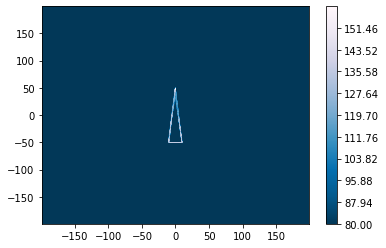

11.342578700001468
Reached Goal |  Start:  [ 0. 50.] Dest:  [-10. -50.] Pos:  [ -9.80725614 -49.02558252] Time of completion: 14:56:23 Time taken:  3.72
Reached Goal |  Start:  [ 0. 50.] Dest:  [ 10. -50.] Pos:  [  9.783571   -49.05257281] Time of completion: 14:56:23 Time taken:  3.52
Reached Goal |  Start:  [-10. -50.] Dest:  [ 10. -50.] Pos:  [  9.02600849 -49.98813358] Time of completion: 14:56:23 Time taken:  3.33
Reached Goal |  Start:  [-10. -50.] Dest:  [ 0. 50.] Pos:  [-0.08325554 49.08497391] Time of completion: 14:56:23 Time taken:  3.69
Reached Goal |  Start:  [ 10. -50.] Dest:  [ 0. 50.] Pos:  [-4.31197208e-02  4.90503607e+01] Time of completion: 14:56:26 Time taken:  2.38
Reached Goal |  Start:  [ 10. -50.] Dest:  [-10. -50.] Pos:  [ -9.07338171 -50.04804224] Time of completion: 14:56:26 Time taken:  2.11
11.324627500000133
Reached Goal |  Start:  [ 0. 50.] Dest:  [-10. -50.] Pos:  [ -9.87799973 -49.04151776] Time of completion: 14:56:42 Time taken:  3.34
Reached Goal |  

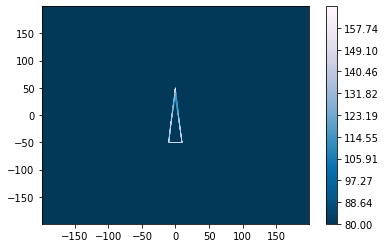

Number of walkers = 60
Walker success rate = 100.0 %
Average time taken = 2.9853333333333336,    Min = 1.7,    Max = 4.11


In [163]:
# main working loop
iterations = 10
walkersperiteration = len(route)
plotfrequency = 2 # number of plots you want (including final), make sure 'iterations' is divisible by this
plotevery = iterations/plotfrequency
stalledpos = []
walker_times = []

for i in range(iterations):
        t11 = time.perf_counter()
        
        #calc_tr_new()
        if __name__ == '__main__': # runs parallelised calc_tr
            with Pool(processes = multiprocessing.cpu_count()) as pool:
                starmapargs = [] # container for starmap arguments
                for core in range(1,multiprocessing.cpu_count()+1):
                    starmapargs.append((core, TrailPotential, z, Weight, subexpdist)) # list of lists of args
                TrailPotential[:,:] = 0
                results = pool.starmap(mpf.calc_tr_new_mp, starmapargs)
                TrailPotential = np.concatenate(np.array(results[0:4]))
                #for ll in results:
                #    TrailPotential += np.array(ll)
                #Trailpotential = results
                #for core in results:

                #pool.close()
                #pool.join()
        t22 = time.perf_counter()
        print(t22-t11)

        intens[:]=0.

        if __name__ == '__main__': # runs parallelised set_up_walker
            with Pool(processes = multiprocessing.cpu_count()) as pool2:
                starmapargs2 = []
                for j in range(walkersperiteration):
                    starmapargs2.append((j, route, intens, xmin, xmax, ymin, ymax, Nx, Ny, stalledpos, x, y, TrailPotential))
                results2 = pool2.starmap(mpf2.set_up_walker_mp, starmapargs2)
                #print(list(results2))
                #start, dest, pos = list(results2[:,1])
                for walker in list(results2):
                    print(walker[7], '|  Start: ', walker[0], 'Dest: ', walker[1], 'Pos: ', walker[2], 'Time of completion:', walker[8], 'Time taken: ', walker[9])
                    track = walker[3] # only keeping last walker's track data, for now
                    # >>>>>>>> fix this >>>>>>>>> if len(walker[5]) != 0: stalledpos+=walker[5] # should only combine if there is a value
                    intens += walker[4] # summing intens from all walkers, hope this doesnt change behaviour
                    grad = walker[6] # not sure if this should be last walker or sum of all
                    walker_times.append(float(walker[9]))
                    #TrailPotential = walker[10]
                    
                #start, dest, pos, track, intens, stalledpos, grad = list(results2)
                #pool2.close()
                #pool2.join()

        update_ground()   
        if (i+1) % plotevery == 0 and i != 0: plot_path()     
        #for j in range(0,walkersperiteration):
            #set_up_walker(np.random.randint(0,len(route))) # used if you want random routes
            #set_up_walker(j) # used if you want to run every route per potential calculation/ iteration
            #setup_potentials()
            #calc_path()
            #now = datetime.now() # referenced elsewhere
            #current_time = now.strftime("%H:%M:%S")
            #print(i, start," -> ", dest, pos,"      time = ", current_time)
        #update_ground()
        
        #plot_path()#

numberofwalkers = iterations*walkersperiteration
successrate = 100-(100*len(stalledpos))/numberofwalkers

print(str("Number of walkers = ")+str(numberofwalkers))
print(str('Walker success rate = ')+str(successrate)+str(' %'))
print('Average time taken = '+str(np.mean(walker_times))+ ',    Min = '+str(min(walker_times))+',    Max = '+str(max(walker_times)))

In [33]:
#plot_path()

In [162]:
for thingy in results:
    print(np.shape(thingy))
    #print(thingy)

for core in range(1,5):
    print(int(((core-1)/4)*len(z)))
    print(int((core/4)*len(z)-1))

#ddddd = [0,1,2,3,4,5]
#print(ddddd[1:3])

print(np.max(TrailPotential))
print(np.mean(TrailPotential))
print(np.min(TrailPotential))

np.where(TrailPotential == -35419.43769596848)

results00 = results[0]

(200, 800)
(200, 800)
(200, 800)
(200, 800)
0
199
200
399
400
599
600
799
2153.2770705469743
1975.2950840831038
500.55293869396434


TypeError: Shapes of x (800, 800) and z (597, 800) do not match

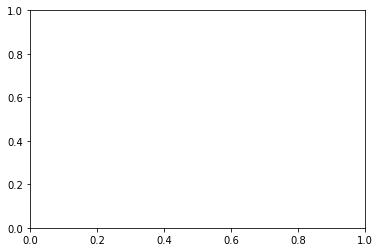

In [34]:
cs = plt.contourf(X, Y, TrailPotential, levels=np.linspace(TrailPotential.min(),TrailPotential.max(),1000),cmap='PuBu_r')
cbar = plt.colorbar()

plt.show()

In [ ]:
for i in range(0,Nx):
    for j in range(0,Ny):
        if (np.isnan(z[i,j])):
            print (i,j,g_max[i,j],Base[i,j,0])

In [ ]:
def detect_local_maxima(arr):
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value 
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_max = (filters.maximum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are 
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # 
    # we create the mask of the background
    background = (arr==0)
    # 
    # a little technicality: we must erode the background in order to 
    # successfully subtract it from local_min, otherwise a line will 
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, 
    # by removing the background from the local_min mask
    detected_maxima = local_max ^ eroded_background
    return np.where(detected_maxima) 

In [ ]:
def plot_potentials():
    global dest
    TotPot = np.zeros((Nx,Ny))
    TotPot =- np.sqrt((dest[0]-x[:,None])**2+(dest[1]-y[None,:])**2)
    TotPot += 0.003*TrailPotential
    maxima=detect_local_maxima(TotPot)
    cs = plt.contourf(X, Y, TotPot, levels=np.linspace(TotPot.min(),TotPot.max(),1000),cmap='PuBu_r')
    cbar = plt.colorbar()
    print(maxima)
    plt.scatter(x[maxima[0]],y[maxima[1]])
    plt.scatter(track[0:wlkr_range-1,0],track[0:wlkr_range-1,1],1)
    plt.show
    # commit test

(array([399, 399, 400, 400], dtype=int64), array([399, 400, 399, 400], dtype=int64))


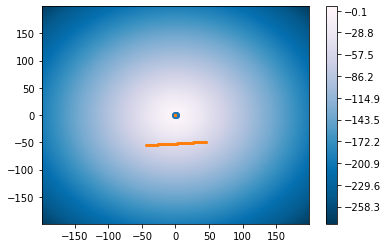

In [ ]:
plot_potentials()

[0. 0.]
[0. 0.]


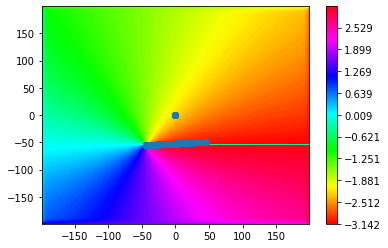

In [ ]:
#Plot the direction
scgrad=np.arctan2(grad[1],grad[0])
levels = np.linspace(-np.pi, np.pi, 360)
cs = plt.contourf(X, Y,scgrad, levels=levels,cmap='hsv')

cbar = plt.colorbar()
plt.scatter(track[0:wlkr_range-1,0],track[0:wlkr_range-1,1])
#plt.scatter(start, dest)
print(start)
print(dest)
plt.show()


In [ ]:
#plot_path3()

In [ ]:
#Integrate z, trapezoid rule eq 20
# def calc_tr():
#    global xi,yi,TrailPotential,expdist,z,Weight,Nx,Ny
#    for xi in range(0,Nx): 
#        for yi in range(0,Ny):
#            TrailPotential[xi,yi]=np.sum(expdist[Nx-1-xi:2*Nx-1-xi,Ny-1-yi:2*Ny-1-yi]*z[:,:]*Weight[:,:])